In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import geojson
from shapely.geometry import Polygon, LineString
from shapely.ops import split
from shapely.geometry import Point, LineString, Polygon
from numpy import ones,vstack
from numpy.linalg import lstsq
import pandas as pd
import csv
import openpyxl
from itertools import islice

In [2]:
pixel_size = 0.346
s1_geo = geojson.load(open('../Inputs/404_1_S1.geojson','rb'))
s1_coordinates = np.array(s1_geo["features"][0]["geometry"]["coordinates"][0]) * pixel_size
s1_pixel_coordinates = np.array(s1_geo["features"][0]["geometry"]["coordinates"][0])

In [3]:
# These 2 points can not be find via an algo, so we need QuPath annotation
bottom_left = np.array([10030.37046,   334.87264])
top_left = np.array([10261.95864,  2615.76   ])

In [46]:
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def get_depth(s1_coordinates, cell_coordinate, slope):
    """
    Args:
        s1_coordinates (np_array): shape(nb_vertices, 2) S1 annotation coordinates
        cell_coordinate(np.array): shape(1, 2): x,y coordinate of the cell
        slope(float): linear fonction slope
    Returns:
    float: percentage of depth
    """
    # compute top point
    b = cell_coordinate[1] - slope * cell_coordinate[0]
    y= s1_coordinates[:,1].max() + 100
    x=(y-b)/slope
    top_point = np.array([x,y])
    # compute button point
    b = cell_coordinate[1] - slope * cell_coordinate[0]
    y= s1_coordinates[:,1].min() - 100
    x=(y-b)/slope
    buttom_point = np.array([x,y])

    line = [(top_point[0],top_point[1]),(buttom_point[0],buttom_point[1])]
    shapely_line = LineString(line)
    polygon = Polygon(s1_coordinates)
    try:
        intersection_line = list(polygon.intersection(shapely_line).coords)
        total_length = distance(intersection_line[0], intersection_line[1])
        cell_to_top_length = distance(cell_coordinate, intersection_line[0])
        return cell_to_top_length / total_length
    except NotImplementedError:
        return math.nan
    

In [47]:
# Compute line slop form S1 top and button left points

In [41]:
points = [bottom_left,top_left]
x_coords, y_coords = zip(*points)
A = vstack([x_coords,ones(len(x_coords))]).T
slope, b = lstsq(A, y_coords)[0]
print("Line Solution is y = {a}x + {b}".format(a=slope,b=b))

Line Solution is y = 9.84889366978922x + -98453.17948913475


/tmp/ipykernel_1138/4037660528.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, b = lstsq(A, y_coords)[0]


In [42]:
# get cells coordinate

In [43]:
input_file = '../Inputs/404_1_cell_position.txt'
wb = openpyxl.Workbook()
ws = wb.worksheets[0]

with open(input_file, 'r') as data:
    reader = csv.reader(data, delimiter='\t')
    for row in reader:
        ws.append(row) 
data = ws.values
cols = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df_404 = pd.DataFrame(data, index=idx, columns=cols)
cells_centroid_x = df_404['Centroid X µm'].to_numpy(dtype=float)
cells_centroid_y = df_404['Centroid Y µm'].to_numpy(dtype=float)

In [48]:
fractions = []
for x, y in zip(cells_centroid_x, cells_centroid_y):
    fractions.append(get_depth(s1_coordinates,  np.array([x, y ]), slope))

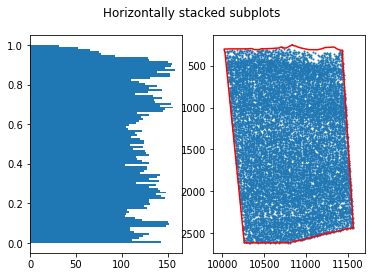

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.axis('equal')
plt.gca().invert_yaxis()
fig.suptitle('Horizontally stacked subplots')
n, bins, patches=ax1.hist(fractions, bins=100, orientation='horizontal')
ax2.plot(s1_coordinates[:,0], s1_coordinates[:,1], 'r')
ax2.scatter(cells_centroid_x, cells_centroid_y, s=1)

In [72]:
plot.plot(densities_as_function_ofpercentage_depth.ipynb)

12479.0